In [1]:
import itertools
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")

import statsmodels.api as sm

In [2]:
# File created: Jan. 5 2019
# Tutorial Reference
# https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [3]:
# Dataset:
# Consumer Price Index for All Urban Consumers: All Items
# Citation:
# U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items [CPIAUCSL], 
# retrieved from FRED, Federal Reserve Bank of St. Louis;
# https://fred.stlouisfed.org/series/CPIAUCSL, January 4, 2019.

In [4]:
import datetime
# Timeit module.
def timeit(method):
    def timed(*args, **kw):
        ts = datetime.datetime.now()
        result = method(*args, **kw)
        te = datetime.datetime.now()
        print(f"Time: {te - ts}")
        return result
    return timed

In [5]:
df = pd.read_csv("./data/CPIAUCSL.csv", index_col=0, parse_dates=True)
# df["DATE"] = pd.to_datetime(df["DATE"])
df.columns = ["CPI"]
print(df.dtypes)
df.head()
# month_df = df.resample("M").mean().head()

CPI    float64
dtype: object


,CPI
DATE,
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95
1947-06-01,22.08


In [6]:
# 1st order differencing.
d1 = df.diff()
d1.dropna(inplace=True)
d1.head()

,CPI
DATE,
1947-03-01,0.38
1947-04-01,0.00
1947-05-01,-0.05
1947-06-01,0.13
1947-07-01,0.15


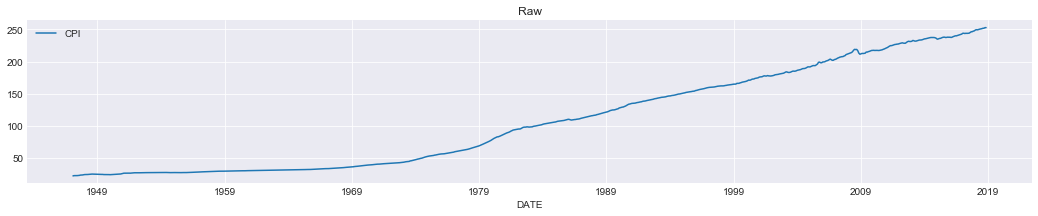

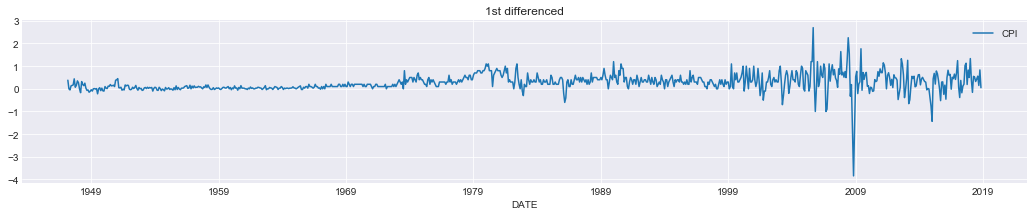

In [7]:
df.plot(figsize=(18, 3), grid=True)
plt.title("Raw")
plt.show()
d1.plot(figsize=(18, 3), grid=True)
plt.title("1st differenced")
plt.show()

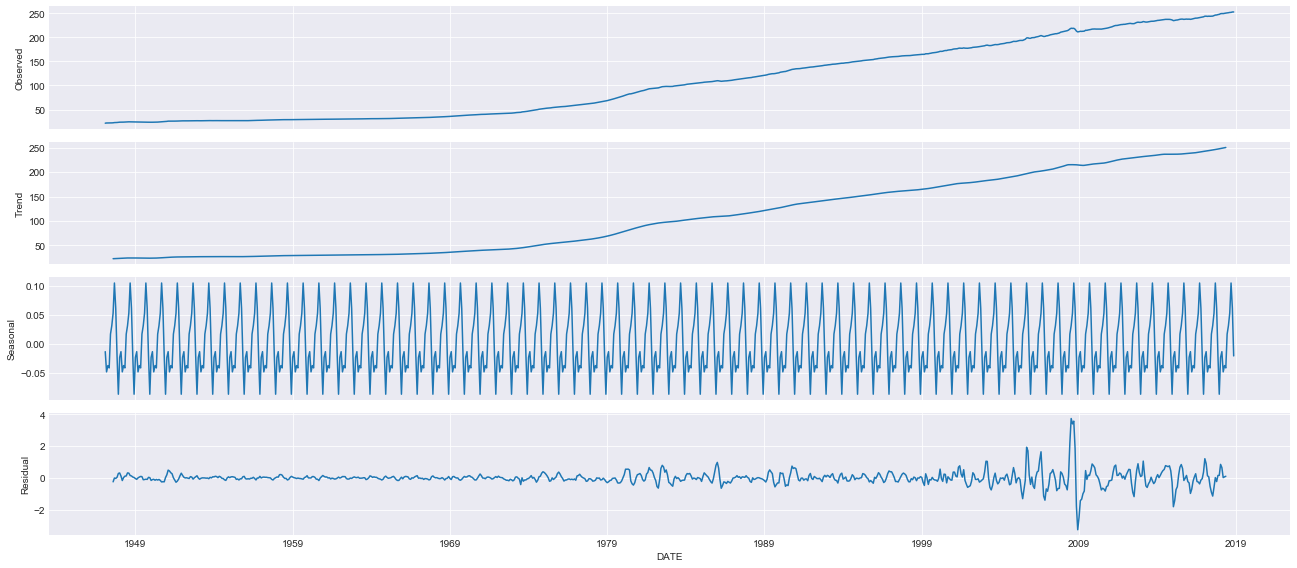

In [8]:
from pylab import rcParams
rcParams["figure.figsize"] = (18, 8)
rcParams["axes.grid"] = True
decomposition = sm.tsa.seasonal_decompose(df, model="additive")
fig = decomposition.plot()
plt.show()

In [9]:
# # Grid Searching for Parameters
# p = d = q = range(3)
# pdq_set = tuple(itertools.product(p, d, q))
# seasonal_pdq_set = (
#     (x[0], x[1], x[2], 12)
#     for x in list(itertools.product(p, d, q))
# )
# candidates = list()

# for param in pdq_set:
#     for param_seasonal in seasonal_pdq_set:
#         model = sm.tsa.statespace.SARIMAX(
#             df,
#             order=param,
#             seasonal_order=param_seasonal,
#             enforce_stationarity=False,
#             enforce_invertibility=False,
#             freq="MS"
#         )
#         results = model.fit()
#         candidates.append({
#             "pdq": param,
#             "seasonal_pdq": param_seasonal,
#             "aic":results.aic
#         })
#         print(f"ARIMA{param}x{param_seasonal} - AIC:{results.aic}")

NameError: name 'results' is not defined

In [ ]:
# Grid Searching for Parameters
p = q = range(10)
d = [1]
pdq_set = tuple(itertools.product(p, d, q))
candidates = list()

for param in pdq_set:
    try:
        model = sm.tsa.statespace.SARIMAX(
            df,
            order=param,
            enforce_stationarity=False,
            enforce_invertibility=False,
            freq="MS"
        )
        candidates.append({
            "pdq": param,
            "aic": results.aic
        })
        results = model.fit()
        print(f"ARIMA{param} - AIC:{results.aic}")
    except:
        continue

In [ ]:
candidates.sort(key=lambda x:x["aic"])
from pprint import pprint
pprint(candidates[:5])
best_param = candidates[0]["pdq"]

In [10]:
# Fitting Seasonal ARIMA
model = sm.tsa.statespace.SARIMAX(
    df,
    order=best_param,
    enforce_stationarity=False,
    enforce_invertibility=False,
    freq="MS"
)

results = model.fit()

NameError: name 'best_param' is not defined

In [11]:
# print(results.summary())

In [12]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

NameError: name 'results' is not defined

In [152]:
pred = results.get_prediction(start=pd.to_datetime("2000-01-01"), dynamic=False)
pred_ci = pred.conf_int()
pred_ci.columns

Index(['lower CPI', 'upper CPI'], dtype='object')

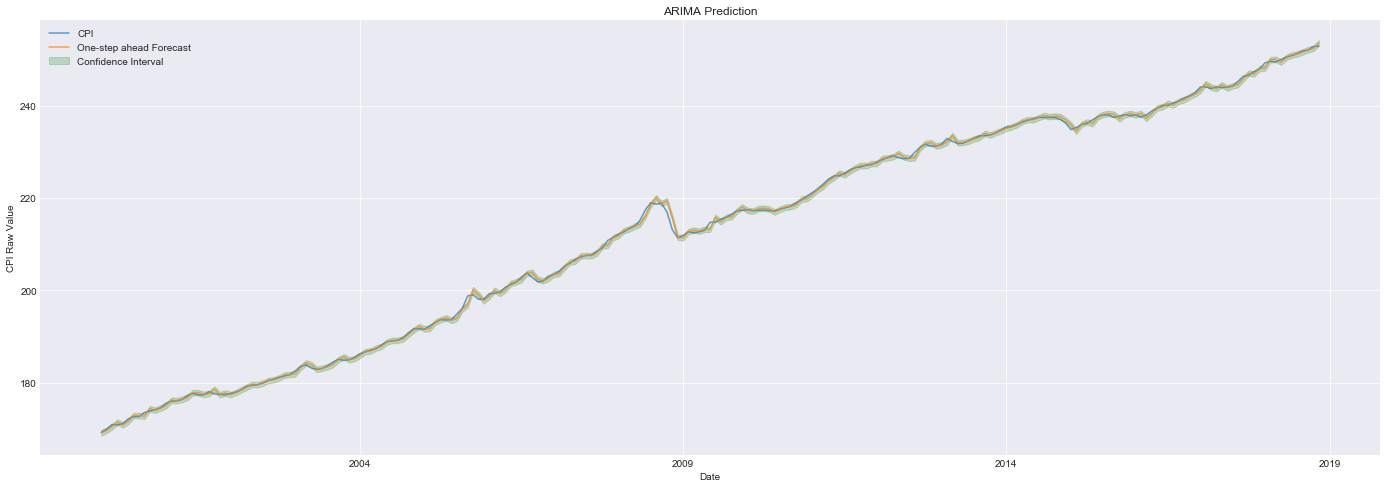

In [153]:
rcParams["figure.figsize"] = (24, 8)
ax = df[pd.to_datetime("2000-01-01"):].plot(label="observed", alpha=.7)
pred.predicted_mean.plot(ax=ax, label="One-step ahead Forecast", alpha=.7)
ax.fill_between(
    pred_ci.index,
    pred_ci["lower CPI"],
    pred_ci["upper CPI"],
    color="green",
    alpha=.2,
    label="Confidence Interval"
)
ax.set_xlabel("Date")
ax.set_ylabel("CPI Raw Value")
plt.title("ARIMA Prediction")
plt.legend()
plt.show()

In [154]:
predicted = pred.predicted_mean.values
observed = np.squeeze(df["2000-01-01":].values)
rmse = np.sqrt(np.mean(
    (predicted - observed) ** 2
))
print(rmse)

0.5359924510048801


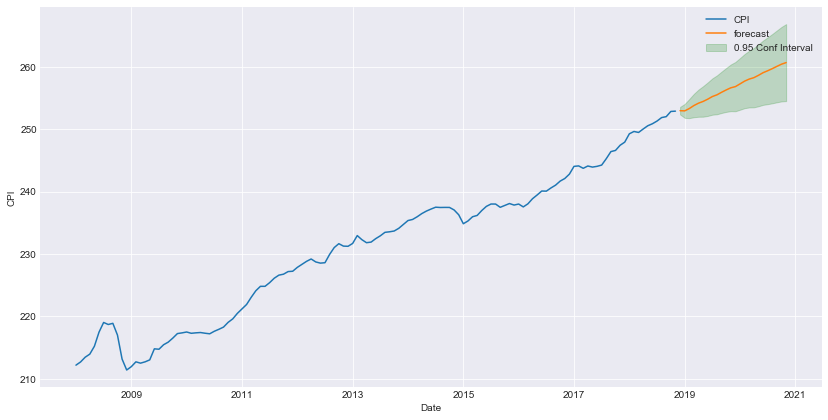

In [189]:
# Forecasting
alpha = 0.05
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int(alpha=alpha)

ax = df["2008-01-01":].plot(
    label="observed", figsize=(14, 7)
)
pred_uc.predicted_mean.plot(ax=ax, label="forecast")
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],  # Lower CI
    pred_ci.iloc[:, 1],  # Upper CI
    color="green",
    alpha=0.2,
    label=f"{1-alpha} Conf Interval"
)
ax.set_xlabel("Date")
ax.set_ylabel("CPI")

plt.legend()
plt.show()

,lower CPI,upper CPI
2018-12-01,252.345821,253.555520
2019-01-01,251.803180,254.033736
2019-02-01,251.756142,254.826816
2019-03-01,251.899893,255.650077
2019-04-01,251.974538,256.333301
2019-05-01,251.983924,256.881345
2019-06-01,252.107061,257.482160
2019-07-01,252.304546,258.127039
2019-08-01,252.375599,258.607208
2019-09-01,252.583278,259.211552
